In [26]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [28]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [29]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [30]:
tf.keras.backend.clear_session()

In [31]:
subject = 'Mato Grosso - Consumo de Cimento (t)'
start_index = 0
split_index = 155
window_size = 36
train_split = split_index + 1 - 12

In [32]:
data = pd.read_csv('2003_mo_model_input_MT.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Mato Grosso - Produção de Cimento (t),Mato Grosso- custo m2 (R$),Mato Grosso - IDH Longevidade,Mato Grosso - Depósito Poupança (R$),Mato Grosso - Consumo de Cimento (t),Mato Grosso - IDH Educacao,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Mato Grosso - Desemprego,Mato Grosso - IDH Renda,Mato Grosso - IDH,Mato Grosso - PIB - Estadual,Mato Grosso - PIB - Construção Civil,Mato Grosso - PIB - Per Capita,Mato Grosso - PIB - Preços de Mercado,Mato Grosso - value,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,50.917240,10522.560000,0.774167,1.402870e+06,47.470,0.713365,1.937098,994.641929,1307.693017,26.497759,22.112509,78.548056,2.038260,8.297178,0.756038,0.745147,6.084564e+07,2.670588e+06,16.831332,5.118946e+07,0.331800,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,50.851586,10614.965000,0.774487,1.418219e+06,45.387,0.713721,2.057965,994.309470,1283.219898,26.168996,21.331689,76.901685,1.862279,8.291317,0.755860,0.745308,6.092768e+07,2.672688e+06,16.835967,5.121614e+07,0.333615,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,50.970549,10702.843148,0.774808,1.433568e+06,44.907,0.714077,1.715492,994.660654,1261.062010,25.844852,20.557682,75.407092,1.802031,8.285457,0.755682,0.745469,6.100973e+07,2.674788e+06,16.840602,5.124282e+07,0.334864,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,51.049978,10785.405648,0.775128,1.448917e+06,45.467,0.714434,1.525801,995.244084,1235.995684,25.435732,19.399042,72.894611,1.794850,8.279596,0.755503,0.745630,6.109177e+07,2.676888e+06,16.845237,5.126950e+07,0.336048,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,51.567529,10863.369096,0.775449,1.464267e+06,56.246,0.714790,1.166060,995.697467,1233.790572,25.082755,17.830386,68.635209,1.820612,8.273735,0.755325,0.745791,6.117381e+07,2.678988e+06,16.849872,5.129619e+07,0.336447,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,37351.487561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,37305.538501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,37240.697573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,37158.452637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


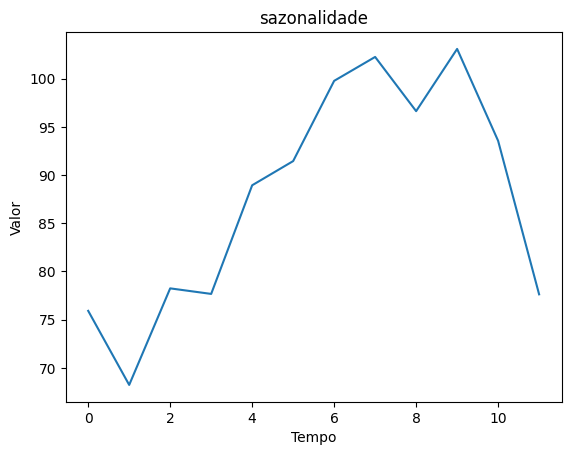

,sazonalidade
sazonalidade,
0,75.915981
1,68.233397
2,78.248121
3,77.672221
4,88.940333
5,91.449042
6,99.770427
7,102.250815
8,96.627989


In [33]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [34]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Mato Grosso - Produção de Cimento (t),Mato Grosso- custo m2 (R$),Mato Grosso - IDH Longevidade,Mato Grosso - Depósito Poupança (R$),Mato Grosso - IDH Educacao,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Mato Grosso - Desemprego,Mato Grosso - IDH Renda,Mato Grosso - IDH,Mato Grosso - PIB - Estadual,Mato Grosso - PIB - Construção Civil,Mato Grosso - PIB - Per Capita,Mato Grosso - PIB - Preços de Mercado,Mato Grosso - value,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Mato Grosso - Consumo de Cimento (t)
0,2003-1,50.917240,10522.560000,0.774167,1.402870e+06,0.713365,1.937098,994.641929,1307.693017,26.497759,22.112509,78.548056,2.038260,8.297178,0.756038,0.745147,6.084564e+07,2.670588e+06,16.831332,5.118946e+07,0.331800,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,75.915981,47.470
1,2003-2,50.851586,10614.965000,0.774487,1.418219e+06,0.713721,2.057965,994.309470,1283.219898,26.168996,21.331689,76.901685,1.862279,8.291317,0.755860,0.745308,6.092768e+07,2.672688e+06,16.835967,5.121614e+07,0.333615,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,68.233397,45.387
2,2003-3,50.970549,10702.843148,0.774808,1.433568e+06,0.714077,1.715492,994.660654,1261.062010,25.844852,20.557682,75.407092,1.802031,8.285457,0.755682,0.745469,6.100973e+07,2.674788e+06,16.840602,5.124282e+07,0.334864,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,78.248121,44.907
3,2003-4,51.049978,10785.405648,0.775128,1.448917e+06,0.714434,1.525801,995.244084,1235.995684,25.435732,19.399042,72.894611,1.794850,8.279596,0.755503,0.745630,6.109177e+07,2.676888e+06,16.845237,5.126950e+07,0.336048,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,77.672221,45.467
4,2003-5,51.567529,10863.369096,0.775449,1.464267e+06,0.714790,1.166060,995.697467,1233.790572,25.082755,17.830386,68.635209,1.820612,8.273735,0.755325,0.745791,6.117381e+07,2.678988e+06,16.849872,5.129619e+07,0.336447,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,88.940333,56.246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,37351.487561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88.940333,NaN
245,2023-6,NaN,37305.538501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91.449042,NaN
246,2023-7,NaN,37240.697573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.770427,NaN
247,2023-8,NaN,37158.452637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102.250815,NaN


In [35]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      55.998
1      49.346
2      57.277
3      61.881
4      65.040
        ...  
244       NaN
245       NaN
246       NaN
247       NaN
248       NaN
Name: Mato Grosso - Consumo de Cimento (t), Length: 249, dtype: float64

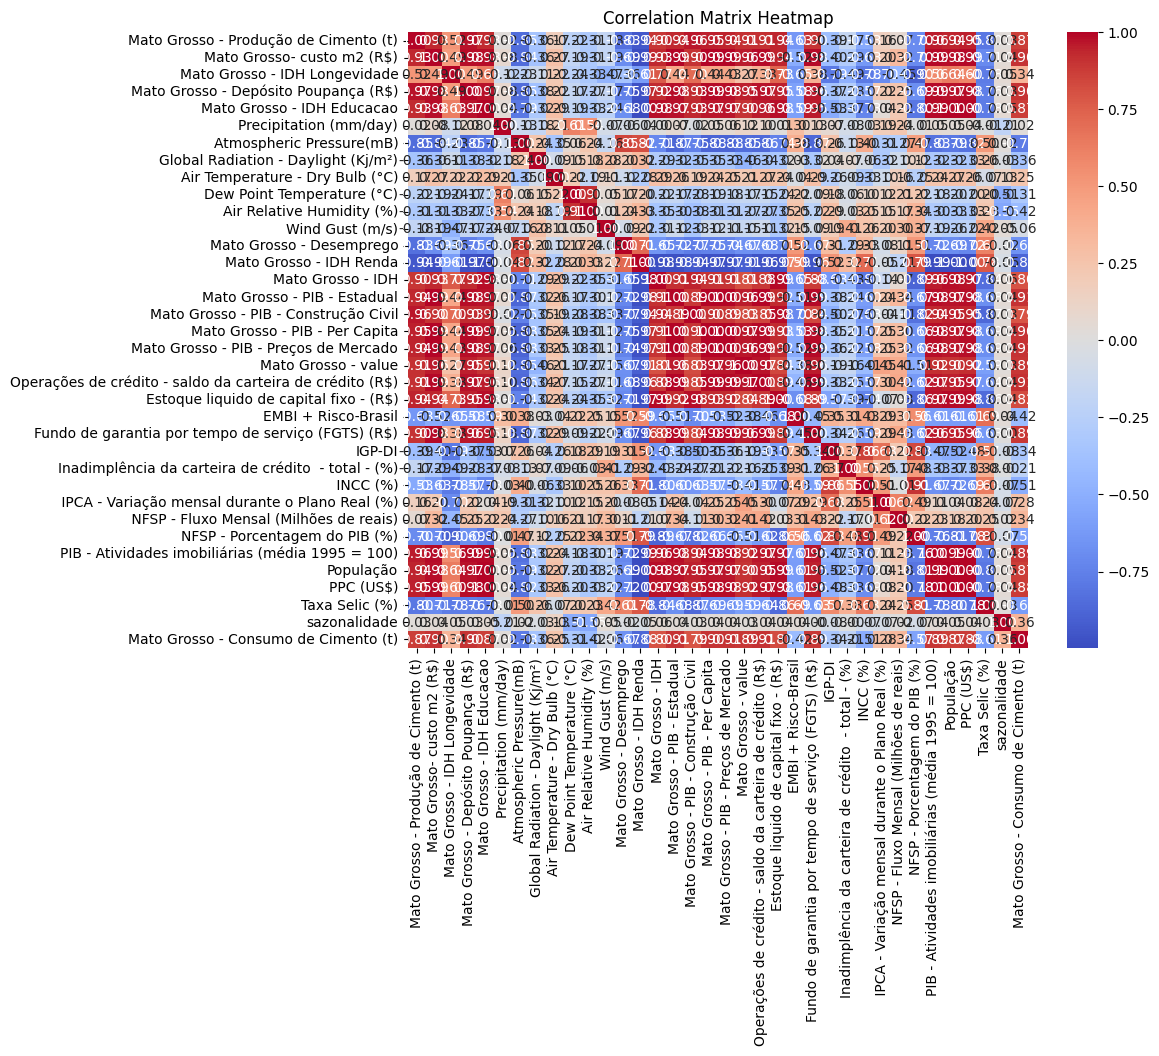

In [36]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [38]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Mato Grosso - Produção de Cimento (t),8.160918e+03
1,Mato Grosso- custo m2 (R$),2.175029e+05
2,Mato Grosso - IDH Longevidade,3.031214e+08
3,Mato Grosso - Depósito Poupança (R$),5.187497e+03
4,Mato Grosso - IDH Educacao,1.308291e+07
5,Precipitation (mm/day),8.835286e+00
6,Atmospheric Pressure(mB),3.097878e+02
7,Global Radiation - Daylight (Kj/m²),1.282294e+01
8,Air Temperature - Dry Bulb (°C),4.856171e+01
9,Dew Point Temperature (°C),3.846001e+02


In [39]:
# data =data.drop(['Air Temperature - Dry Bulb (°C)',
#                  'Precipitation (mm/day)',
#                  'Global Radiation - Daylight (Kj/m²)', 
#                  'Air Relative Humidity (%)'], axis=1)
data = remove_high_vif_columns(safe_data, 1000000)
data

Num columns removed: 9


,Mato Grosso - Produção de Cimento (t),Mato Grosso- custo m2 (R$),Mato Grosso - Depósito Poupança (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Mato Grosso - Desemprego,Mato Grosso - PIB - Estadual,Mato Grosso - value,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
0,50.917240,10522.560000,1.402870e+06,1.937098,994.641929,1307.693017,26.497759,22.112509,78.548056,2.038260,8.297178,6.084564e+07,0.331800,3.846831e+05,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,169.247665,1.611498,75.915981
1,50.851586,10614.965000,1.418219e+06,2.057965,994.309470,1283.219898,26.168996,21.331689,76.901685,1.862279,8.291317,6.092768e+07,0.333615,3.852662e+05,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,170.176810,1.450389,68.233397
2,50.970549,10702.843148,1.433568e+06,1.715492,994.660654,1261.062010,25.844852,20.557682,75.407092,1.802031,8.285457,6.100973e+07,0.334864,3.853051e+05,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,171.135713,1.870184,78.248121
3,51.049978,10785.405648,1.448917e+06,1.525801,995.244084,1235.995684,25.435732,19.399042,72.894611,1.794850,8.279596,6.109177e+07,0.336048,3.857521e+05,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,172.116904,1.355287,77.672221
4,51.567529,10863.369096,1.464267e+06,1.166060,995.697467,1233.790572,25.082755,17.830386,68.635209,1.820612,8.273735,6.117381e+07,0.336447,3.871640e+05,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,173.072271,1.585538,88.940333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,92.454214,22877.686791,3.659310e+06,1.874070,984.665579,639.234672,28.179797,17.134018,56.317785,1.716435,7.775613,7.598331e+07,0.440823,3.143856e+06,336.843217,9.124085e+06,0.471500,3.103302,0.501878,0.527374,-1005.696691,2.438647,192.698092,390.589413,1.078474,102.250815
152,92.016745,22964.615104,3.646091e+06,2.338846,984.197997,710.766745,28.280410,18.327133,59.444164,1.738397,7.766663,7.604931e+07,0.440156,3.159665e+06,345.939329,9.111628e+06,0.475422,3.177535,0.489257,0.525404,-1039.159506,2.375528,192.754385,391.798431,0.962516,96.627989
153,91.604160,23048.695559,3.632873e+06,2.562041,983.735833,744.433551,27.968766,19.500975,64.191509,1.764157,7.757714,7.611531e+07,0.439652,3.177292e+06,356.198303,9.630300e+06,0.447600,3.254167,0.489071,0.522000,-1243.715598,2.307250,192.810678,393.032398,1.138989,103.082441
154,91.201170,23142.594869,3.619655e+06,2.665371,983.574096,806.170465,28.162705,20.352517,66.068143,1.817799,7.748765,7.618132e+07,0.439108,3.192250e+06,363.318059,1.020613e+07,0.426394,3.330340,0.486059,0.509714,-1329.246736,2.242645,192.715004,394.326420,1.038436,93.551936


In [40]:
input_data = data.iloc[:split_index + 1,1:-1]
# mean = np.mean(input_data, axis=0)
# stddev =  np.std(input_data, axis=0)
# input_data = ((input_data - mean) /stddev)
scaler=MinMaxScaler()
scaled_data = scaler.fit_transform(input_data)
input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Mato Grosso- custo m2 (R$),Mato Grosso - Depósito Poupança (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Mato Grosso - Desemprego,Mato Grosso - PIB - Estadual,Mato Grosso - value,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,0.000000,0.000000,0.336775,0.912870,0.080500,0.517405,1.000000,1.000000,0.943601,1.000000,0.000000,0.182887,0.000000,0.108706,0.016690,1.000000,0.912229,1.000000,1.000000,0.543630,1.000000,0.000000,0.000000,0.807549
1,0.007267,0.006093,0.359949,0.887077,0.078989,0.428403,0.903498,0.943223,0.859609,0.996341,0.005327,0.195974,0.000207,0.058377,0.005415,0.934664,0.910339,0.961590,0.898644,0.544990,0.965719,0.001830,0.004103,0.687691
2,0.014178,0.012186,0.294285,0.914322,0.077621,0.340651,0.807838,0.891680,0.830854,0.992682,0.010654,0.204977,0.000221,0.100305,0.001062,0.903684,0.909866,0.936241,0.836703,0.532585,0.927412,0.003660,0.008337,1.000000
3,0.020671,0.018278,0.257914,0.959586,0.076073,0.229895,0.664640,0.805034,0.827427,0.989023,0.015980,0.213516,0.000380,0.211591,0.000000,0.854353,0.909131,0.911951,0.809101,0.504220,0.885588,0.005490,0.012670,0.616940
4,0.026802,0.024371,0.188939,0.994760,0.075937,0.134338,0.470769,0.658143,0.839723,0.985364,0.021307,0.216392,0.000881,0.358835,0.002490,0.819481,0.905479,0.963424,0.772577,0.515509,0.838034,0.007747,0.016889,0.788236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,0.971643,0.895690,0.324690,0.138889,0.039226,0.972762,0.384704,0.233361,0.790001,0.674386,0.982858,0.969025,0.980090,0.341211,0.837927,0.143160,0.305639,0.047659,0.409150,0.997036,0.057396,0.993627,0.977394,0.411003
152,0.978480,0.890443,0.413804,0.102614,0.043642,1.000000,0.532162,0.341178,0.800483,0.668799,0.987144,0.964222,0.985706,0.361289,0.836471,0.149108,0.387048,0.021964,0.403230,0.993528,0.050845,0.994471,0.982733,0.324736
153,0.985092,0.885196,0.456599,0.066758,0.045721,0.915633,0.677238,0.504897,0.812778,0.663212,0.991429,0.960584,0.991968,0.383934,0.897087,0.106917,0.471089,0.021585,0.393004,0.972085,0.043758,0.995316,0.988182,0.456024
154,0.992476,0.879949,0.476411,0.054211,0.049533,0.968135,0.782481,0.569615,0.838380,0.657625,0.995715,0.956660,0.997280,0.399650,0.964383,0.074759,0.554626,0.015452,0.356091,0.963119,0.037052,0.993880,0.993896,0.381217


In [41]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Mato Grosso- custo m2 (R$),Mato Grosso - Depósito Poupança (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Mato Grosso - Desemprego,Mato Grosso - PIB - Estadual,Mato Grosso - value,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,0.000000,0.000000,0.336775,0.912870,0.080500,0.517405,1.000000,1.000000,0.943601,1.000000,0.000000,0.182887,0.000000,0.108706,0.016690,1.000000,0.912229,1.000000,1.000000,0.543630,1.000000,0.000000,0.000000,0.807549
1,0.007267,0.006093,0.359949,0.887077,0.078989,0.428403,0.903498,0.943223,0.859609,0.996341,0.005327,0.195974,0.000207,0.058377,0.005415,0.934664,0.910339,0.961590,0.898644,0.544990,0.965719,0.001830,0.004103,0.687691
2,0.014178,0.012186,0.294285,0.914322,0.077621,0.340651,0.807838,0.891680,0.830854,0.992682,0.010654,0.204977,0.000221,0.100305,0.001062,0.903684,0.909866,0.936241,0.836703,0.532585,0.927412,0.003660,0.008337,1.000000
3,0.020671,0.018278,0.257914,0.959586,0.076073,0.229895,0.664640,0.805034,0.827427,0.989023,0.015980,0.213516,0.000380,0.211591,0.000000,0.854353,0.909131,0.911951,0.809101,0.504220,0.885588,0.005490,0.012670,0.616940
4,0.026802,0.024371,0.188939,0.994760,0.075937,0.134338,0.470769,0.658143,0.839723,0.985364,0.021307,0.216392,0.000881,0.358835,0.002490,0.819481,0.905479,0.963424,0.772577,0.515509,0.838034,0.007747,0.016889,0.788236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0.878534,0.960578,0.382275,0.236077,0.041600,0.749623,0.485713,0.383746,0.808490,0.624309,0.925419,0.994292,0.881396,0.145335,0.767121,0.369541,0.134802,0.160109,0.756416,0.799973,0.094876,0.999733,0.929945,0.302580
140,0.886101,0.954946,0.467650,0.218775,0.042657,0.778470,0.614021,0.491200,0.819154,0.642146,0.930908,0.997216,0.891920,0.149790,0.770809,0.373663,0.107661,0.168785,0.755278,0.803815,0.095765,0.999867,0.932690,0.229929
141,0.893633,0.949314,0.549992,0.234321,0.044895,0.728116,0.690312,0.582609,0.805165,0.659983,0.936396,1.000000,0.904492,0.156217,0.823469,0.383080,0.063009,0.169823,0.745299,0.692895,0.095412,1.000000,0.935504,0.334488
142,0.901412,0.943682,0.871946,0.233154,0.044889,0.650319,0.769141,0.692304,0.806215,0.677820,0.941884,0.999637,0.916359,0.164797,0.886163,0.372850,0.017943,0.168006,0.739572,0.764133,0.094477,0.997032,0.938403,0.291661


In [42]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0       55.998000
1       49.346000
2       57.277000
3       61.881000
4       65.040000
          ...    
139    120.634902
140    114.449394
141    119.204159
142    107.200487
143     93.395000
Name: Mato Grosso - Consumo de Cimento (t), Length: 144, dtype: float64

In [43]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [44]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(108, 36, 24)

In [45]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Mato Grosso- custo m2 (R$),Mato Grosso - Depósito Poupança (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Mato Grosso - Desemprego,Mato Grosso - PIB - Estadual,Mato Grosso - value,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
108,0.674747,0.741349,0.566233,0.030260,0.065140,0.550611,0.788191,0.747999,0.829232,0.000000,0.697620,0.668031,0.584672,0.046476,0.576729,0.241213,0.894461,0.269958,0.246811,0.011842,0.021268,0.788736,0.794730,0.126286
109,0.680378,0.755686,0.638045,0.074865,0.063850,0.483022,0.779016,0.768412,0.776600,0.019431,0.706009,0.676250,0.592860,0.049796,0.547631,0.257717,0.933771,0.247038,0.255042,0.061730,0.022371,0.801322,0.800825,0.136300
110,0.686117,0.770023,0.607554,0.131219,0.060973,0.380134,0.738794,0.773189,0.754431,0.038862,0.714399,0.685906,0.603045,0.050154,0.547834,0.301698,0.961400,0.246383,0.284608,0.066764,0.024066,0.813907,0.806817,0.198981
111,0.691886,0.784360,0.525864,0.184653,0.057339,0.268637,0.621102,0.706420,0.744200,0.058293,0.722789,0.695554,0.613555,0.048907,0.541336,0.299812,0.983561,0.261807,0.314835,0.043925,0.025253,0.826493,0.812425,0.124912
112,0.697874,0.798697,0.456728,0.243059,0.055484,0.252674,0.402686,0.522264,0.751220,0.077724,0.731178,0.705197,0.623825,0.044925,0.547192,0.255504,0.984745,0.316206,0.306260,0.095032,0.028261,0.839666,0.818016,0.032369
113,0.703859,0.813034,0.338554,0.253020,0.056326,0.397491,0.243979,0.338073,0.779566,0.097155,0.739568,0.714836,0.633509,0.039367,0.555211,0.207948,0.987221,0.266153,0.311235,0.101029,0.031624,0.852839,0.823761,0.039834
114,0.709841,0.827371,0.305285,0.217633,0.057702,0.580021,0.201807,0.222152,0.799133,0.116586,0.747958,0.725941,0.642425,0.033811,0.557537,0.169207,0.990146,0.267539,0.309980,0.105226,0.034133,0.866013,0.829544,0.042221
115,0.717277,0.841708,0.335229,0.155705,0.058420,0.731356,0.271836,0.235169,0.813052,0.136017,0.756348,0.735633,0.652070,0.026160,0.563561,0.122054,1.000000,0.243993,0.301380,0.132974,0.034686,0.878234,0.835366,0.092363
116,0.723278,0.856045,0.421958,0.084097,0.059664,0.795820,0.447836,0.360481,0.821610,0.155448,0.764737,0.745417,0.662246,0.018514,0.562394,0.079036,0.985009,0.240073,0.312886,0.163856,0.036283,0.890455,0.840978,0.158579
117,0.728792,0.870382,0.423785,0.035088,0.058468,0.728853,0.641382,0.551320,0.822331,0.174879,0.773127,0.758213,0.675009,0.010641,0.609785,0.065481,0.946695,0.238489,0.304865,0.176276,0.036400,0.902676,0.846397,0.091050


In [46]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 24)

In [47]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(180, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.14,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][20:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[3970579273, 398858205, 693209349, 3197569815, 712325041, 2103029883, 321597029, 4277229986, 1681552137, 2353914690]


Step: 0 ___________________________________________
val_loss: 80.7380599975586
winner_seed: 3970579273


Step: 1 ___________________________________________
val_loss: 65.07157135009766
winner_seed: 398858205


Step: 2 ___________________________________________
val_loss: 108.8233871459961


Step: 3 ___________________________________________
val_loss: 61.82615661621094
winner_seed: 3197569815


Step: 4 ___________________________________________
val_loss: 98.15296173095703


Step: 5 ___________________________________________
val_loss: 100.21833038330078


Step: 6 ___________________________________________
val_loss: 85.39244079589844


Step: 7 ___________________________________________
val_loss: 88.83802795410156


Step: 8 ___________________________________________
val_loss: 111.53004455566406


Step: 9 ___________________________________________
val_loss: 56.118206

In [51]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
3/3 [==============================] - 2s 191ms/step - loss: 10411.9561 - val_loss: 313.0179
Epoch 2/10000
3/3 [==============================] - 0s 15ms/step - loss: 694.8879 - val_loss: 311.0499
Epoch 3/10000
3/3 [==============================] - 0s 14ms/step - loss: 759.4758 - val_loss: 630.3717
Epoch 4/10000
3/3 [==============================] - 0s 13ms/step - loss: 759.5844 - val_loss: 309.2383
Epoch 5/10000
3/3 [==============================] - 0s 14ms/step - loss: 700.3843 - val_loss: 313.4235
Epoch 6/10000
3/3 [==============================] - 0s 14ms/step - loss: 734.9473 - val_loss: 479.9396
Epoch 7/10000
3/3 [==============================] - 0s 15ms/step - loss: 738.4768 - val_loss: 314.0582
Epoch 8/10000
3/3 [==============================] - 0s 14ms/step - loss: 815.7767 - val_loss: 346.6498
Epoch 9/10000
3/3 [==============================] - 0s 14ms/step - loss: 971.8442 - val_loss: 768.1443
Epoch 10/10000
3/3 [==============================] - 0s 14ms

3/3 [==============================] - 0s 14ms/step - loss: 253.0784 - val_loss: 992.0357
Epoch 80/10000
3/3 [==============================] - 0s 14ms/step - loss: 298.2037 - val_loss: 534.6476
Epoch 81/10000
3/3 [==============================] - 0s 13ms/step - loss: 355.8962 - val_loss: 1309.0176
Epoch 82/10000
3/3 [==============================] - 0s 15ms/step - loss: 331.3892 - val_loss: 720.5986
Epoch 83/10000
3/3 [==============================] - 0s 14ms/step - loss: 232.6150 - val_loss: 672.7493
Epoch 84/10000
3/3 [==============================] - 0s 14ms/step - loss: 210.3962 - val_loss: 710.6879
Epoch 85/10000
3/3 [==============================] - 0s 14ms/step - loss: 225.9095 - val_loss: 787.3242
Epoch 86/10000
3/3 [==============================] - 0s 13ms/step - loss: 221.5421 - val_loss: 573.2090
Epoch 87/10000
3/3 [==============================] - 0s 12ms/step - loss: 394.1572 - val_loss: 1112.9719
Epoch 88/10000
3/3 [==============================] - 0s 14ms/step -

3/3 [==============================] - 0s 14ms/step - loss: 96.3983 - val_loss: 457.1581
Epoch 157/10000
3/3 [==============================] - 0s 13ms/step - loss: 126.9230 - val_loss: 733.0984
Epoch 158/10000
3/3 [==============================] - 0s 14ms/step - loss: 144.9162 - val_loss: 175.9037
Epoch 159/10000
3/3 [==============================] - 0s 13ms/step - loss: 143.6841 - val_loss: 719.6791
Epoch 160/10000
3/3 [==============================] - 0s 14ms/step - loss: 98.7271 - val_loss: 1124.8036
Epoch 161/10000
3/3 [==============================] - 0s 15ms/step - loss: 203.5207 - val_loss: 1449.6273
Epoch 162/10000
3/3 [==============================] - 0s 13ms/step - loss: 294.3203 - val_loss: 226.3999
Epoch 163/10000
3/3 [==============================] - 0s 13ms/step - loss: 205.9138 - val_loss: 868.3610
Epoch 164/10000
3/3 [==============================] - 0s 14ms/step - loss: 122.4706 - val_loss: 629.1449
Epoch 165/10000
3/3 [==============================] - 0s 14ms

Epoch 234/10000
3/3 [==============================] - 0s 13ms/step - loss: 71.9600 - val_loss: 732.3588
Epoch 235/10000
3/3 [==============================] - 0s 12ms/step - loss: 72.9131 - val_loss: 219.5466
Epoch 236/10000
3/3 [==============================] - 0s 13ms/step - loss: 72.1494 - val_loss: 679.7047
Epoch 237/10000
3/3 [==============================] - 0s 14ms/step - loss: 56.6231 - val_loss: 321.7907
Epoch 238/10000
3/3 [==============================] - 0s 14ms/step - loss: 83.0580 - val_loss: 744.3005
Epoch 239/10000
3/3 [==============================] - 0s 14ms/step - loss: 53.0590 - val_loss: 619.8717
Epoch 240/10000
3/3 [==============================] - 0s 14ms/step - loss: 54.6929 - val_loss: 605.0349
Epoch 241/10000
3/3 [==============================] - 0s 14ms/step - loss: 51.8761 - val_loss: 553.7653
Epoch 242/10000
3/3 [==============================] - 0s 14ms/step - loss: 52.5111 - val_loss: 407.1880
Epoch 243/10000
3/3 [==============================] - 

Epoch 312/10000
3/3 [==============================] - 0s 14ms/step - loss: 54.2493 - val_loss: 424.6511
Epoch 313/10000
3/3 [==============================] - 0s 13ms/step - loss: 44.6257 - val_loss: 423.0365
Epoch 314/10000
3/3 [==============================] - 0s 14ms/step - loss: 47.8157 - val_loss: 301.1736
Epoch 315/10000
3/3 [==============================] - 0s 14ms/step - loss: 41.1611 - val_loss: 284.9778
Epoch 316/10000
3/3 [==============================] - 0s 14ms/step - loss: 48.7153 - val_loss: 495.1860
Epoch 317/10000
3/3 [==============================] - 0s 14ms/step - loss: 58.4724 - val_loss: 244.2106
Epoch 318/10000
3/3 [==============================] - 0s 13ms/step - loss: 48.0674 - val_loss: 335.5102
Epoch 319/10000
3/3 [==============================] - 0s 13ms/step - loss: 42.7810 - val_loss: 260.4650
Epoch 320/10000
3/3 [==============================] - 0s 15ms/step - loss: 45.3604 - val_loss: 401.1324
Epoch 321/10000
3/3 [==============================] - 

3/3 [==============================] - 0s 15ms/step - loss: 53.6556 - val_loss: 551.9911
Epoch 391/10000
3/3 [==============================] - 0s 15ms/step - loss: 42.4787 - val_loss: 338.1118
Epoch 392/10000
3/3 [==============================] - 0s 14ms/step - loss: 46.3897 - val_loss: 183.8134
Epoch 393/10000
3/3 [==============================] - 0s 14ms/step - loss: 60.1493 - val_loss: 702.7994
Epoch 394/10000
3/3 [==============================] - 0s 13ms/step - loss: 85.3814 - val_loss: 408.3876
Epoch 395/10000
3/3 [==============================] - 0s 12ms/step - loss: 55.2722 - val_loss: 346.7924
Epoch 396/10000
3/3 [==============================] - 0s 13ms/step - loss: 56.3667 - val_loss: 221.6340
Epoch 397/10000
3/3 [==============================] - 0s 15ms/step - loss: 59.9037 - val_loss: 621.7303
Epoch 398/10000
3/3 [==============================] - 0s 14ms/step - loss: 41.8307 - val_loss: 315.7320
Epoch 399/10000
3/3 [==============================] - 0s 14ms/step - l

3/3 [==============================] - 0s 13ms/step - loss: 40.5990 - val_loss: 277.0975
Epoch 469/10000
3/3 [==============================] - 0s 12ms/step - loss: 42.0291 - val_loss: 206.7572
Epoch 470/10000
3/3 [==============================] - 0s 13ms/step - loss: 52.0506 - val_loss: 421.9822
Epoch 471/10000
3/3 [==============================] - 0s 13ms/step - loss: 42.3133 - val_loss: 235.0387
Epoch 472/10000
3/3 [==============================] - 0s 13ms/step - loss: 39.1751 - val_loss: 383.3482
Epoch 473/10000
3/3 [==============================] - 0s 12ms/step - loss: 39.2643 - val_loss: 419.5595
Epoch 474/10000
3/3 [==============================] - 0s 13ms/step - loss: 48.3081 - val_loss: 200.8015
Epoch 475/10000
3/3 [==============================] - 0s 12ms/step - loss: 38.6665 - val_loss: 260.2645
Epoch 476/10000
3/3 [==============================] - 0s 13ms/step - loss: 36.6740 - val_loss: 420.6591
Epoch 477/10000
3/3 [==============================] - 0s 13ms/step - l

3/3 [==============================] - 0s 13ms/step - loss: 47.0647 - val_loss: 465.4799
Epoch 547/10000
3/3 [==============================] - 0s 13ms/step - loss: 35.5061 - val_loss: 407.2872
Epoch 548/10000
3/3 [==============================] - 0s 13ms/step - loss: 43.5999 - val_loss: 336.9318
Epoch 549/10000
3/3 [==============================] - 0s 14ms/step - loss: 43.9119 - val_loss: 433.8375
Epoch 550/10000
3/3 [==============================] - 0s 14ms/step - loss: 35.1361 - val_loss: 384.9554
Epoch 551/10000
3/3 [==============================] - 0s 14ms/step - loss: 45.6675 - val_loss: 524.1545
Epoch 552/10000
3/3 [==============================] - 0s 13ms/step - loss: 44.6014 - val_loss: 341.4219
Epoch 553/10000
3/3 [==============================] - 0s 14ms/step - loss: 38.8689 - val_loss: 298.1326
Epoch 554/10000
3/3 [==============================] - 0s 12ms/step - loss: 50.3734 - val_loss: 541.4182
Epoch 555/10000
3/3 [==============================] - 0s 14ms/step - l

3/3 [==============================] - 0s 14ms/step - loss: 30.1176 - val_loss: 461.7744
Epoch 625/10000
3/3 [==============================] - 0s 13ms/step - loss: 30.2541 - val_loss: 254.5684
Epoch 626/10000
3/3 [==============================] - 0s 14ms/step - loss: 37.5271 - val_loss: 519.1752
Epoch 627/10000
3/3 [==============================] - 0s 13ms/step - loss: 37.4182 - val_loss: 438.3160
Epoch 628/10000
3/3 [==============================] - 0s 13ms/step - loss: 38.2717 - val_loss: 368.2661
Epoch 629/10000
3/3 [==============================] - 0s 14ms/step - loss: 36.6001 - val_loss: 337.0887
Epoch 630/10000
3/3 [==============================] - 0s 12ms/step - loss: 38.2591 - val_loss: 385.5858
Epoch 631/10000
3/3 [==============================] - 0s 13ms/step - loss: 35.9337 - val_loss: 448.4340
Epoch 632/10000
3/3 [==============================] - 0s 14ms/step - loss: 44.3935 - val_loss: 332.1529
Epoch 633/10000
3/3 [==============================] - 0s 13ms/step - l

3/3 [==============================] - 0s 13ms/step - loss: 39.3053 - val_loss: 304.8860
Epoch 703/10000
3/3 [==============================] - 0s 14ms/step - loss: 36.3743 - val_loss: 381.2698
Epoch 704/10000
3/3 [==============================] - 0s 13ms/step - loss: 29.1184 - val_loss: 394.3492
Epoch 705/10000
3/3 [==============================] - 0s 13ms/step - loss: 31.9483 - val_loss: 422.2400
Epoch 706/10000
3/3 [==============================] - 0s 13ms/step - loss: 30.0965 - val_loss: 404.7725
Epoch 707/10000
3/3 [==============================] - 0s 13ms/step - loss: 30.4721 - val_loss: 510.9018
Epoch 708/10000
3/3 [==============================] - 0s 14ms/step - loss: 28.7209 - val_loss: 334.6248
Epoch 709/10000
3/3 [==============================] - 0s 13ms/step - loss: 28.9879 - val_loss: 280.1447
Epoch 710/10000
3/3 [==============================] - 0s 14ms/step - loss: 35.9270 - val_loss: 526.7119
Epoch 711/10000
3/3 [==============================] - 0s 13ms/step - l

3/3 [==============================] - 0s 14ms/step - loss: 129.7277 - val_loss: 257.3202
Epoch 780/10000
3/3 [==============================] - 0s 13ms/step - loss: 146.4249 - val_loss: 373.8842
Epoch 781/10000
3/3 [==============================] - 0s 12ms/step - loss: 129.6505 - val_loss: 174.1012
Epoch 782/10000
3/3 [==============================] - 0s 14ms/step - loss: 159.5695 - val_loss: 475.5367
Epoch 783/10000
3/3 [==============================] - 0s 14ms/step - loss: 172.8373 - val_loss: 114.4096
Epoch 784/10000
3/3 [==============================] - 0s 13ms/step - loss: 279.3226 - val_loss: 517.8074
Epoch 785/10000
3/3 [==============================] - 0s 13ms/step - loss: 126.6229 - val_loss: 386.3279
Epoch 786/10000
3/3 [==============================] - 0s 13ms/step - loss: 142.1432 - val_loss: 237.9756
Epoch 787/10000
3/3 [==============================] - 0s 12ms/step - loss: 109.4697 - val_loss: 408.8380
Epoch 788/10000
3/3 [==============================] - 0s 13ms

Epoch 857/10000
3/3 [==============================] - 0s 13ms/step - loss: 90.5140 - val_loss: 167.3951
Epoch 858/10000
3/3 [==============================] - 0s 13ms/step - loss: 79.7646 - val_loss: 174.8168
Epoch 859/10000
3/3 [==============================] - 0s 12ms/step - loss: 164.9282 - val_loss: 383.6707
Epoch 860/10000
3/3 [==============================] - 0s 13ms/step - loss: 95.5525 - val_loss: 204.7960
Epoch 861/10000
3/3 [==============================] - 0s 13ms/step - loss: 74.8086 - val_loss: 259.5418
Epoch 862/10000
3/3 [==============================] - 0s 14ms/step - loss: 69.8054 - val_loss: 168.0605
Epoch 863/10000
3/3 [==============================] - 0s 13ms/step - loss: 77.0602 - val_loss: 176.3955
Epoch 864/10000
3/3 [==============================] - 0s 13ms/step - loss: 77.2302 - val_loss: 325.7115
Epoch 865/10000
3/3 [==============================] - 0s 12ms/step - loss: 95.1349 - val_loss: 184.6154
Epoch 866/10000
3/3 [==============================] -

Epoch 935/10000
3/3 [==============================] - 0s 11ms/step - loss: 66.6407 - val_loss: 252.9917
Epoch 936/10000
3/3 [==============================] - 0s 12ms/step - loss: 70.6958 - val_loss: 255.6808
Epoch 937/10000
3/3 [==============================] - 0s 11ms/step - loss: 61.8394 - val_loss: 211.8883
Epoch 938/10000
3/3 [==============================] - 0s 12ms/step - loss: 73.5169 - val_loss: 863.4379
Epoch 939/10000
3/3 [==============================] - 0s 12ms/step - loss: 282.3520 - val_loss: 56.1182
Epoch 940/10000
3/3 [==============================] - 0s 12ms/step - loss: 183.1140 - val_loss: 276.5666
Epoch 941/10000
3/3 [==============================] - 0s 11ms/step - loss: 110.7649 - val_loss: 217.2649
Epoch 942/10000
3/3 [==============================] - 0s 11ms/step - loss: 77.9462 - val_loss: 232.8649
Epoch 943/10000
3/3 [==============================] - 0s 11ms/step - loss: 71.2061 - val_loss: 132.2970
Epoch 944/10000
3/3 [==============================] 

Epoch 1013/10000
3/3 [==============================] - 0s 13ms/step - loss: 53.0545 - val_loss: 225.2525
Epoch 1014/10000
3/3 [==============================] - 0s 14ms/step - loss: 57.2897 - val_loss: 150.8050
Epoch 1015/10000
3/3 [==============================] - 0s 11ms/step - loss: 58.5964 - val_loss: 176.2946
Epoch 1016/10000
3/3 [==============================] - 0s 14ms/step - loss: 70.5669 - val_loss: 255.3382
Epoch 1017/10000
3/3 [==============================] - 0s 14ms/step - loss: 57.2640 - val_loss: 401.1398
Epoch 1018/10000
3/3 [==============================] - 0s 14ms/step - loss: 57.8997 - val_loss: 216.7481
Epoch 1019/10000
3/3 [==============================] - 0s 14ms/step - loss: 53.6979 - val_loss: 227.2541
Epoch 1020/10000
3/3 [==============================] - 0s 13ms/step - loss: 53.8850 - val_loss: 194.0682
Epoch 1021/10000
3/3 [==============================] - 0s 14ms/step - loss: 60.6303 - val_loss: 203.7653
Epoch 1022/10000
3/3 [========================

3/3 [==============================] - 0s 13ms/step - loss: 48.7048 - val_loss: 516.0065
Epoch 1091/10000
3/3 [==============================] - 0s 14ms/step - loss: 50.4197 - val_loss: 245.7941
Epoch 1092/10000
3/3 [==============================] - 0s 13ms/step - loss: 55.8173 - val_loss: 725.1803
Epoch 1093/10000
3/3 [==============================] - 0s 14ms/step - loss: 57.7112 - val_loss: 473.2151
Epoch 1094/10000
3/3 [==============================] - 0s 13ms/step - loss: 51.9120 - val_loss: 319.2869
Epoch 1095/10000
3/3 [==============================] - 0s 13ms/step - loss: 57.5891 - val_loss: 412.2992
Epoch 1096/10000
3/3 [==============================] - 0s 13ms/step - loss: 55.1644 - val_loss: 451.0135
Epoch 1097/10000
3/3 [==============================] - 0s 13ms/step - loss: 51.8532 - val_loss: 334.1402
Epoch 1098/10000
3/3 [==============================] - 0s 14ms/step - loss: 50.6611 - val_loss: 292.4217
Epoch 1099/10000
3/3 [==============================] - 0s 15ms

3/3 [==============================] - 0s 14ms/step - loss: 51.5123 - val_loss: 346.2638
Epoch 1168/10000
3/3 [==============================] - 0s 13ms/step - loss: 48.0245 - val_loss: 434.4377
Epoch 1169/10000
3/3 [==============================] - 0s 13ms/step - loss: 53.5196 - val_loss: 464.4799
Epoch 1170/10000
3/3 [==============================] - 0s 15ms/step - loss: 50.8777 - val_loss: 254.1180
Epoch 1171/10000
3/3 [==============================] - 0s 13ms/step - loss: 51.8051 - val_loss: 350.1542
Epoch 1172/10000
3/3 [==============================] - 0s 15ms/step - loss: 50.5914 - val_loss: 527.7836
Epoch 1173/10000
3/3 [==============================] - 0s 14ms/step - loss: 56.5554 - val_loss: 346.4427
Epoch 1174/10000
3/3 [==============================] - 0s 15ms/step - loss: 50.3592 - val_loss: 366.0693
Epoch 1175/10000
3/3 [==============================] - 0s 14ms/step - loss: 52.7272 - val_loss: 502.5482
Epoch 1176/10000
3/3 [==============================] - 0s 14ms

3/3 [==============================] - 0s 13ms/step - loss: 53.3053 - val_loss: 404.5605
Epoch 1245/10000
3/3 [==============================] - 0s 14ms/step - loss: 52.5746 - val_loss: 270.6817
Epoch 1246/10000
3/3 [==============================] - 0s 13ms/step - loss: 52.4758 - val_loss: 470.4109
Epoch 1247/10000
3/3 [==============================] - 0s 12ms/step - loss: 47.0719 - val_loss: 373.7765
Epoch 1248/10000
3/3 [==============================] - 0s 13ms/step - loss: 45.2326 - val_loss: 402.4020
Epoch 1249/10000
3/3 [==============================] - 0s 14ms/step - loss: 63.1455 - val_loss: 353.3868
Epoch 1250/10000
3/3 [==============================] - 0s 14ms/step - loss: 45.1187 - val_loss: 386.1976
Epoch 1251/10000
3/3 [==============================] - 0s 15ms/step - loss: 46.0764 - val_loss: 465.3864
Epoch 1252/10000
3/3 [==============================] - 0s 14ms/step - loss: 44.0060 - val_loss: 401.3961
Epoch 1253/10000
3/3 [==============================] - 0s 13ms

3/3 [==============================] - 0s 13ms/step - loss: 43.8213 - val_loss: 527.8370
Epoch 1322/10000
3/3 [==============================] - 0s 14ms/step - loss: 58.1806 - val_loss: 450.6053
Epoch 1323/10000
3/3 [==============================] - 0s 13ms/step - loss: 49.7108 - val_loss: 255.0823
Epoch 1324/10000
3/3 [==============================] - 0s 13ms/step - loss: 62.0692 - val_loss: 553.0057
Epoch 1325/10000
3/3 [==============================] - 0s 14ms/step - loss: 48.1238 - val_loss: 437.9383
Epoch 1326/10000
3/3 [==============================] - 0s 14ms/step - loss: 45.7910 - val_loss: 403.4901
Epoch 1327/10000
3/3 [==============================] - 0s 13ms/step - loss: 46.1442 - val_loss: 435.7110
Epoch 1328/10000
3/3 [==============================] - 0s 13ms/step - loss: 42.1099 - val_loss: 417.8924
Epoch 1329/10000
3/3 [==============================] - 0s 14ms/step - loss: 41.0294 - val_loss: 421.3332
Epoch 1330/10000
3/3 [==============================] - 0s 14ms

3/3 [==============================] - 0s 14ms/step - loss: 54.7737 - val_loss: 377.0061
Epoch 1399/10000
3/3 [==============================] - 0s 14ms/step - loss: 49.6503 - val_loss: 336.6360
Epoch 1400/10000
3/3 [==============================] - 0s 13ms/step - loss: 44.3027 - val_loss: 340.6747
Epoch 1401/10000
3/3 [==============================] - 0s 13ms/step - loss: 57.8896 - val_loss: 269.3450
Epoch 1402/10000
3/3 [==============================] - 0s 12ms/step - loss: 54.1135 - val_loss: 382.0907
Epoch 1403/10000
3/3 [==============================] - 0s 13ms/step - loss: 44.8912 - val_loss: 387.0101
Epoch 1404/10000
3/3 [==============================] - 0s 14ms/step - loss: 50.0242 - val_loss: 219.5407
Epoch 1405/10000
3/3 [==============================] - 0s 14ms/step - loss: 49.1268 - val_loss: 356.2111
Epoch 1406/10000
3/3 [==============================] - 0s 14ms/step - loss: 48.6513 - val_loss: 330.9998
Epoch 1407/10000
3/3 [==============================] - 0s 13ms

In [52]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [53]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 17ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,100.639664,99.593132,99.140617,100.52652,103.023117,105.853714,109.266022,113.660736,116.40052,116.862961,113.587601,107.331909
Target,83.13,65.293,90.338,83.188,107.23,105.397,120.055,125.769,112.904,123.201,112.725,90.828
Error,17.509666,34.300133,8.80262,17.338516,4.206886,0.456711,10.788979,12.108261,3.496521,6.338036,0.862602,16.503906


In [54]:
display(mae)
display(mape)

11.059402

0.12860836

In [55]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [56]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 15ms/step
Ano-11: |Prediction[[1285.8865]] - Target[1220.058]| =  Error: [[65.82849]]; MAPE:[[0.05395522]]


[array([[65.82849]], dtype=float32)]

65.82849

0.053955216